In [1]:
import pandas as pd
import json

In [8]:
data = []
#olddata
with open("happy.json", "r") as f:
    data.append(json.load(f))
    
with open("sad.json", "r") as f:
    data.append(json.load(f))

In [9]:
dfs = []
labels = [True, False]
for l, d in zip(labels, data):
    tmp = pd.DataFrame(d)
    tmp['label'] = l
    dfs.append(tmp)
df = pd.concat(dfs)
df.head()

fullname                                               html  \
0      はぁ｡  <p class="TweetTextSize js-tweet-text tweet-te...   
1    みずたまり  <p class="TweetTextSize js-tweet-text tweet-te...   
2   かんちぇらら  <p class="TweetTextSize js-tweet-text tweet-te...   
3  弾丸ツーリング  <p class="TweetTextSize js-tweet-text tweet-te...   
4   かずひろここ  <p class="TweetTextSize js-tweet-text tweet-te...   

                    id likes replies retweets  \
0  1033865886099103744     0       0        0   
1  1033865876817100800     0       0        0   
2  1033865871679057921     0       0        0   
3  1033865860375445505     0       0        0   
4  1033865858924208128     0       0        0   

                                                text            timestamp  \
0   昨日のましゃみたいにパーカーの上から重ね着ね\nメガホンもセットで\n逆にライブでしか着れないね  2018-08-26T23:56:50   
1  こちら夏休みは終わりましたが夏休みの課題は終わってないのでスニョンと一緒にがんばろ〜〜〜〜絶...  2018-08-26T23:56:47   
2  蒼さん、復帰おめでとうございます\n今日も１日、頑張ってください　くれぐれも無理しないで行き...  2018-08-26T23:56:46   
3  @atsukann123 年中熱燗さん、おはようございます\nメッセージ採用おめでとうござい...  2018-08-26T23:56:44   
4  おはようございます静岡公演のレポ楽しく読ませていただきましたありがとうございました 次はすぐ...  2018-08-26T23:56:43   

                                          url            user  label  
0     /mashazuki91/status/1033865886099103744     mashazuki91   True  
1          /nrsrnh/status/1033865876817100800          nrsrnh   True  
2      /rodbksk154/status/1033865871679057921      rodbksk154   True  
3  /DANGAN_TOURING/status/1033865860375445505  DANGAN_TOURING   True  
4    /kakahirococo/status/1033865858924208128    kakahirococo   True

In [10]:
df[df['label'] == True]['likes'].astype(int).mean(), df[df['label'] == False]['likes'].astype(int).mean()

(4.187675374229528, 2.5968390943517847)

In [14]:
import MeCab

In [13]:
from sklearn.utils import shuffle
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
df = shuffle(df)

X = df['text'].tolist()
y = df['label'].tolist()
tagger = MeCab.Tagger("-Owakati")

X = list(map(tagger.parse, X))

In [16]:
class  TfIdfWord2VecVectorizer:
    def __init__(self):
        pass

    def fit(self, X, y):
        self.tfidf_model = TfidfVectorizer(min_df=3, max_df=20000).fit(X)
        return self

    def transform(self, X):
        return self.tfidf_and_w2v(X, self.tfidf_model)

    def texts_encoder(self, texts):
        with tf.Graph().as_default():
            embed = hub.Module("https://tfhub.dev/google/nnlm-en-dim128/1")
            embeddings = embed(texts)
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                sess.run(tf.tables_initializer())
                result = sess.run(embeddings)
        return result

    def tfidf_and_w2v(self, X, tfidf_model):
        tmp = tfidf_model.transform(X)
        a = tmp.toarray()
        if isinstance(X, pd.core.series.Series):
            X = X.tolist()
        b = self.texts_encoder(X)
        return np.hstack((a, b))

pipe = Pipeline([('vector',TfIdfWord2VecVectorizer()), ("clf", LogisticRegression(penalty='l2'))])
np.mean(cross_val_score(pipe, X, y, cv=3))

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Initialize variable module/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Initialize variable module/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Initialize variable module/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Initialize variable module/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Initialize variable module/embeddin

0.7439102564102563

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
pipe.fit(X_train, y_train)

INFO:tensorflow:Initialize variable module/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings


Pipeline(memory=None,
     steps=[('vector', <__main__.TfIdfWord2VecVectorizer object at 0x7f67abb2cfd0>), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [19]:
y_pred = pipe.predict(X_test)

INFO:tensorflow:Initialize variable module/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings


In [20]:
from sklearn.metrics import classification_report

In [23]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.76      0.71      0.73      1594
       True       0.71      0.76      0.74      1526

avg / total       0.74      0.73      0.73      3120



In [26]:
from sklearn.metrics import roc_auc_score


In [32]:
auc = roc_auc_score(y_test, y_pred)
auc

0.7348744719302891

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

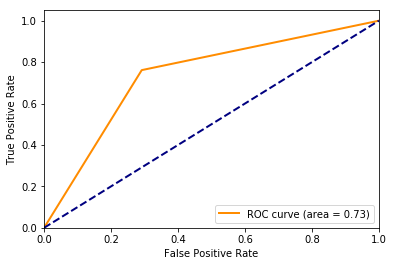

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()